In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import glob

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from catboost import CatBoostClassifier

## Extraction and preprocessing

In [7]:
# Creating a variable for data from one of the 12 chunks
chunk_0_df = pd.read_parquet('../data/train_data/train_data_0.pq')

In [8]:
# Creating a variable for the labels
target = pd.read_csv('../data/train_target.csv')

In [9]:
chunk_0_df.head()

,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_21,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag
0,0,1,18,9,2,3,16,10,11,3,...,3,3,3,4,1,3,4,1,0,0
1,0,2,18,9,14,14,12,12,0,3,...,0,0,0,4,1,3,4,1,0,0
2,0,3,18,9,4,8,1,11,11,0,...,0,0,0,4,1,2,3,1,1,1
3,0,4,4,1,9,12,16,7,12,2,...,3,3,3,4,1,3,1,1,0,0
4,0,5,5,12,15,2,11,12,10,2,...,3,3,3,4,1,3,4,1,0,0


In [10]:
# Creating a function for extracting data from a chunk and removing the 'rn' column
def extraction(data_file):
    extracted_data = pd.read_parquet(data_file)
    extracted_data = extracted_data.drop('rn', axis=1)

    return extracted_data

In [11]:
# Creating a function for generating new features from the existing ones
def generate_new_features(data):
    data['total_delinquencies'] = data[['is_zero_loans5', 'is_zero_loans530', 'is_zero_loans3060', 'is_zero_loans6090', 'is_zero_loans90']].sum(axis=1)

    data['total_undefined_days'] = data[['pclose_flag', 'fclose_flag']].sum(axis=1)

    return data

In [12]:
# Creating a function that encodes the data using one hot encoding
def encoding(dataset):
    id_column = dataset['id']
    ohe = OneHotEncoder(sparse=False)
    encoded_data = ohe.fit_transform(dataset.drop('id', axis=1))
    df_encoded = pd.DataFrame(data=encoded_data, columns=ohe.get_feature_names_out(),)
    df_encoded = pd.concat([id_column, df_encoded], axis=1).reset_index(drop=True)

    return df_encoded

In [13]:
# This function groups the data by the 'id' column and applies the aggregation function of summation
def group_aggregate(dataset, function):
    agg_data = dataset.groupby('id').agg(function).reset_index()

    return agg_data

In [14]:
# This fucntion applies the previously created fucntions to each of the data chunks, concatenates
def process_data_chunk(data_chunk, existing_data=None):
    extracted_data = extraction(data_chunk)
    new_features_data = generate_new_features(extracted_data)
    encoded_data = encoding(new_features_data)
    aggregated_data = group_aggregate(encoded_data, function='sum')

    if existing_data is None:
        return aggregated_data
    else:
        combined_data = pd.concat([existing_data, aggregated_data], join='outer', ignore_index=True, sort=False)
        combined_data = combined_data.fillna(0)

    return combined_data

In [15]:
existing_data = None
data_files = glob.glob('../data/train_data/train_data_*.pq')

for data_file in data_files:
    existing_data = process_data_chunk(data_file, existing_data)

df_final = pd.merge(existing_data, target, how='inner', on='id')
df_final.to_parquet('../data/final_data.pq')


## Modeling

In [16]:
df = pd.read_parquet('../data/final_data.pq')

In [17]:
df.head(15)

,id,pre_since_opened_0,pre_since_opened_1,pre_since_opened_2,pre_since_opened_3,pre_since_opened_4,pre_since_opened_5,pre_since_opened_6,pre_since_opened_7,pre_since_opened_8,...,total_undefined_days_2,pre_loans5_11,pre_loans3060_6,pre_since_confirmed_15,pre_loans3060_4,pre_loans6090_0,pre_loans3060_3,pre_loans_total_overdue_1,pre_loans_max_overdue_sum_0,flag
0,2250000,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,2250001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,2250002,0.0,0.0,1.0,0.0,0.0,1.0,1.0,2.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,2250003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,2250004,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,2250005,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
6,2250006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7,2250007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
8,2250008,1.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
9,2250009,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [18]:
df.shape

(3000000, 430)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['id', 'flag'], axis=1), df['flag'], train_size=0.7, stratify=df['flag'], random_state=42)

In [20]:
model = CatBoostClassifier(auto_class_weights='Balanced', depth=7, l2_leaf_reg=0.8)

model.fit(X_train, y_train)

train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

print(f'train score: {roc_auc_score(y_train, train_pred)}')
print(f'test score: {roc_auc_score(y_test, test_pred)}')

0:	learn: 0.6895261	total: 574ms	remaining: 9m 33s
1:	learn: 0.6860345	total: 1.07s	remaining: 8m 54s
2:	learn: 0.6828450	total: 1.56s	remaining: 8m 37s
3:	learn: 0.6798368	total: 2.05s	remaining: 8m 31s
4:	learn: 0.6768885	total: 2.52s	remaining: 8m 22s
5:	learn: 0.6740899	total: 3.01s	remaining: 8m 19s
6:	learn: 0.6715034	total: 3.53s	remaining: 8m 20s
7:	learn: 0.6690097	total: 4.08s	remaining: 8m 25s
8:	learn: 0.6667684	total: 4.63s	remaining: 8m 29s
9:	learn: 0.6645121	total: 5.1s	remaining: 8m 25s
10:	learn: 0.6624407	total: 5.64s	remaining: 8m 27s
11:	learn: 0.6604336	total: 6.14s	remaining: 8m 25s
12:	learn: 0.6584696	total: 6.64s	remaining: 8m 24s
13:	learn: 0.6566984	total: 7.15s	remaining: 8m 23s
14:	learn: 0.6550719	total: 7.62s	remaining: 8m 20s
15:	learn: 0.6535032	total: 8.14s	remaining: 8m 20s
16:	learn: 0.6518469	total: 8.67s	remaining: 8m 21s
17:	learn: 0.6501817	total: 9.15s	remaining: 8m 19s
18:	learn: 0.6487977	total: 9.67s	remaining: 8m 19s
19:	learn: 0.6474107	to

In [21]:
print(confusion_matrix(y_test, test_pred))

[[593320 274747]
 [  9573  22360]]


Text(0.5, 1.0, 'roc-auc for test')

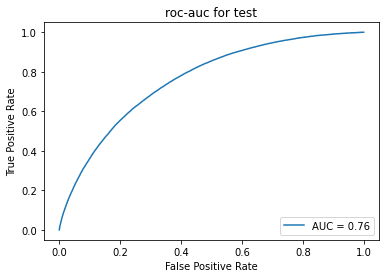

In [22]:
# Creating a plot showing the ROC-AUC curve and the score
y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
plt.title('roc-auc for test')